In [29]:
import glob
import os
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from src.datagenerator import DataGenerator, DataLoader, z_score
from src.performance_evaluation import compute_PCA, plot_confusion_matrix, plot_PCA
from src.util import plot_voxel
from src.performance_evaluation import (
    compute_position_error,
    compute_volume_error,
)

# load vae model
from src.vae import vae_model

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
print(tf.__version__)

2.16.1


# Stage 2

**1. Training of the material classificator $\Upsilon$**

**2. Training of the mapper $\Xi$**

## Material classificator $\Upsilon$

**CNN**

In [ ]:
datagenerator = False

params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "supervised": "material",  # "diameter", "material", "anomaly", "anomaly_and_material"
    "batch_size": 128,
    "shuffle": True,
    "EIT_shape": "matrix",
}

if datagenerator:
    idx = np.arange(0, len(os.listdir(params["path"])))
    np.random.shuffle(idx)

    limit_index = 100_000

    training_generator = DataGenerator(idx[:limit_index], **params)
    test_____generator = DataGenerator(idx[limit_index:], **params)
    X, Y = training_generator[0]
else:
    X, Y = DataLoader(params)
    X = z_score(X)
    X = np.expand_dims(X, axis=3)
    print(X.shape, Y.shape)

In [ ]:
print(X.shape, Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42
)

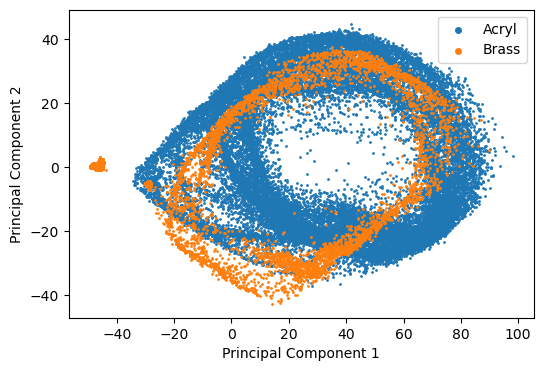

In [6]:
data_pca = compute_PCA(X_train)
plot_PCA(data_pca, Y_train)

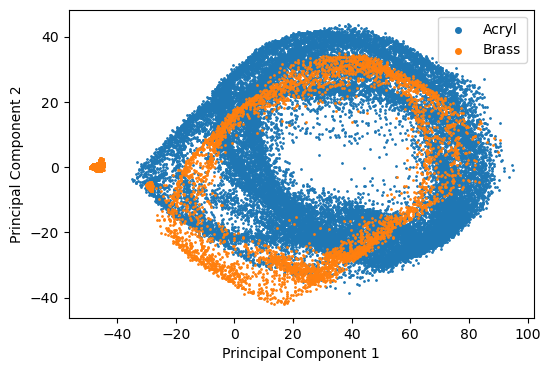

In [7]:
data_pca = compute_PCA(X_test)
plot_PCA(data_pca, Y_test)

In [8]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(62100, 64, 64, 1) (62100, 64, 64, 1) (62100,) (62100,)


In [9]:
def material_classificator_model_CNN(input_shape=(64, 64, 1), latent_dim=1, kernel=3):
    # optional aditional layer
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    mapper_input = tf.keras.layers.Input(shape=input_shape)
    # normalize input data
    # x = Xscaler(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)


material_classificator_CNN = material_classificator_model_CNN()
material_classificator_CNN.summary()

2024-05-14 09:49:16.009484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46873 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217 (16.47 KB)

 Trainable params: 4,217 (16.47 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
material_classificator_CNN.compile(tf.optimizers.Adam(learning_rate=0.005), loss="mse")

In [11]:
if datagenerator:
    classificator_history_CNN = material_classificator_CNN.fit(
        training_generator, epochs=50, batch_size=128
    )
else:
    classificator_history_CNN = material_classificator_CNN.fit(
        X_train,
        Y_train,
        epochs=20,
        batch_size=params["batch_size"],
    )

material_classificator_CNN.save_weights("models/material_mapper.weights.h5")

Epoch 1/20


I0000 00:00:1715680158.116420  352067 service.cc:145] XLA service 0x7f0e6400b040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715680158.116472  352067 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-14 09:49:18.223483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 09:49:18.369014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 93/486 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1093

I0000 00:00:1715680159.552063  352067 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0416
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.1669e-04
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 9/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.6511e-04
Epoch 10/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7709e-04
Epoch 11/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010
Epoch 12/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7167e-04
Epoch 13/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5532e-04
Epoch 14/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7110e-04
Epoch 15/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 

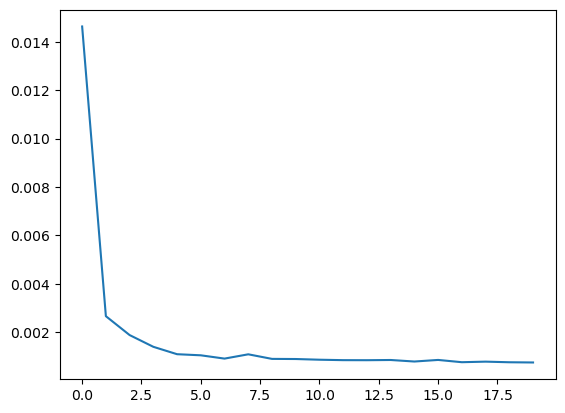

In [12]:
plt.plot(classificator_history_CNN.history["loss"])

In [11]:
Y_pred = np.concatenate(np.round(material_classificator_CNN.predict(X_test)))

1941/1941 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [12]:
s_path = "models/mapper_4/"

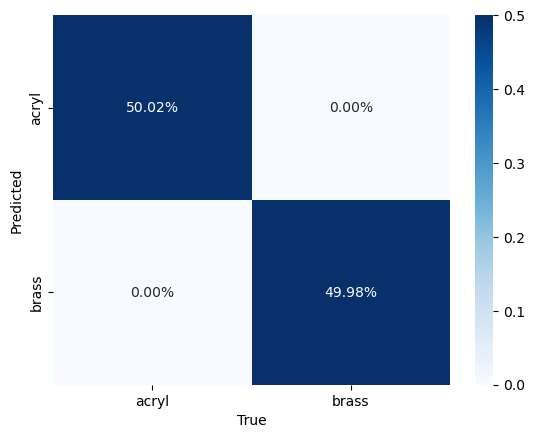

In [13]:
plot_confusion_matrix(Y_test, np.abs(Y_pred), s_path)

In [47]:
# os.mkdir(s_path)
material_classificator_CNN.save(f"{s_path}/model.keras")
np.savez(s_path + "/test_data.npz", X_test=X_test, Y_test=Y_test, params=params)

## Mapper $\Xi$

Loat the VAE model and train the two required mapper.

In [359]:
vae = vae_model()
vae.load_weights("models/vaes/vae_17.weights.h5")
vae.summary()

Φ = vae.encoder
Ψ = vae.decoder

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_encoder (Functional)        │ ?                      │        13,662 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_decoder (Functional)        │ ?                      │        17,933 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,595 (123.42 KB)

 Trainable params: 31,533 (123.18 KB)

 Non-trainable params: 62 (248.00 B)

In [5]:
params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "EIT_shape": "matrix",
    "supervised": "anomaly_and_material",  # "diameter", "material", "anomaly", "anomaly_and_material"
    "batch_size": 128,
    "shuffle": False,
}

In [6]:
X, Y, m = DataLoader(params)

X = z_score(X)
X = np.expand_dims(X, axis=3)
Y = np.expand_dims(Y, axis=4)

100%|██████████| 124200/124200 [50:11<00:00, 41.24it/s] 


In [360]:
X_train, X_test, gamma_train, gamma_test, m_train, m_test = train_test_split(
    X, Y, m, test_size=0.1, random_state=42
)
# del X,Y,m

In [8]:
_, _, z_train = Φ.predict(gamma_train)

2024-05-21 14:36:20.079302: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29302456320 exceeds 10% of free system memory.
2024-05-21 14:37:10.223051: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29302456320 exceeds 10% of free system memory.
I0000 00:00:1716302236.089557 2265676 service.cc:145] XLA service 0x7f886004a240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716302236.089640 2265676 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-21 14:37:16.165641: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 14:37:16.344674: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  34/3494 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step 

I0000 00:00:1716302236.940419 2265676 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3494/3494 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


In [9]:
_, _, z_test = Φ.predict(gamma_test)

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [362]:
print(X_train.shape, gamma_train.shape, m_train.shape, z_train.shape)
print(X_test.shape, gamma_test.shape, m_test.shape, z_test.shape)

(111780, 64, 64, 1) (111780, 32, 32, 32, 1) (111780,) (111780, 8)
(12420, 64, 64, 1) (12420, 32, 32, 32, 1) (12420,) (12420, 8)


In [367]:
# |------------------------------------- HPT ------------------------------------|
# | model  1: epochs = 500, batch_size = 64, kernels = 3, strides=(2, 2), loss = mae, predictable=% |
# |*model  2: epochs = 500, batch_size = 64, kernels = 3, strides=(3, 3), loss = mae, predictable=%. |
# |*model  3: epochs = 500, batch_size = 64, kernels = 3, strides=(2, 4), loss = mae, predictable=%. |
# |*model  4: epochs = 500, batch_size = 64, kernels = 3, strides=(3, 4), loss = mae, predictable=%|
# |*model  5: epochs = 500, batch_size = 64, kernels = 3, strides=(4, 4), loss = mae, predictable=%.|
# |
# |*model  6: epochs = 500, batch_size = 64, kernels = 9, strides=(2, 2), loss = mae, predictable=% |
# |*model  7: epochs = 500, batch_size = 64, kernels = 3, strides=(2, 4), loss = mae, predictable= |
# |*model  8: epochs = 500, batch_size = 64, kernels = 9, strides=(2, 2), loss = mae, predictable= |
# |*model  9: epochs = 500, batch_size = 64, kernels = 11, strides=(2, 2), loss = mae, predictable=|
# |*model  0: epochs = 500, batch_size = 64, kernels = 13, strides=(2, 2), loss = mae, predictable= |
# |--------------------------------------------------------------------------------------------|


def mapper_CNN(input_shape=(64, 64, 1), latent_dim=8):
    mapper_input = tf.keras.layers.Input(shape=input_shape)

    strides = (2, 2)
    kernel = 3

    x = tf.keras.layers.Conv2D(
        filters=2, kernel_size=kernel, strides=strides, padding="same"
    )(mapper_input)
    x = tf.keras.layers.Conv2D(
        filters=4, kernel_size=kernel, strides=strides, padding="same"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=8, kernel_size=kernel, strides=strides, padding="same"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=16, kernel_size=kernel, strides=strides, padding="same"
    )(x)
    x = tf.keras.layers.Flatten()(x)

    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)


Ξ = mapper_CNN()
Ξ.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mae")
Ξ.summary()

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 32, 32, 2)      │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 16, 16, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 8, 8, 8)        │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,616 (14.12 KB)

 Trainable params: 3,616 (14.12 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = Ξ.fit(X_train, z_train, batch_size=64, epochs=500)

Epoch 1/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2292
Epoch 2/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2026
Epoch 3/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1909
Epoch 4/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1839
Epoch 5/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1792
Epoch 6/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1752
Epoch 7/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1715
Epoch 8/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1690
Epoch 9/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1669
Epoch 10/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1653
Epoch 11/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1640
Epoch 12/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1627
Epoch 13/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1611
Epoch 14/500
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1607
Epoch 15/500
17

In [ ]:
for keys in history.history.keys():
    plt.plot(history.history[keys], label=keys)
    plt.legend()
plt.show()

**Test the mapper $\Xi$ performance**

The variable `γ_hat` represents $\hat{\gamma}$, which is the reconstructed conductivity distribution.
It is generated by:
$$\hat{\gamma} = \Psi(\Xi(\mathbf{u}))$$

In [ ]:
γ_hat = Ψ.predict(Ξ.predict(X_test))
γ_hat = np.squeeze(γ_hat, axis=4)
γ_hat = np.clip(γ_hat, a_min=0, a_max=1)
γ_hat[γ_hat != 0] = 1
print(γ_hat.shape)

In [ ]:
plt.style.use("default")
for rdn in np.random.randint(low=0, high=γ_hat.shape[0], size=5):
    print("True γ distribution")
    plot_voxel(gamma_test[rdn, :, :, :, 0])
    print("Predicted γ distribution")
    plot_voxel(γ_hat[rdn])
    print("---------")

In [ ]:
mapper_idx = len(glob.glob("models/mappers/*.h5")) + 1
mapper_idx

In [ ]:
acc_measure = dict(Model=list(), Error_val=list(), Error=list(), test_idx=list())

data_append = []

for idx, v_err in enumerate(compute_volume_error(γ_hat, gamma_test)):
    if v_err != None:
        v_percent = (v_err / 32**3) * 100
        data_append.append(
            dict(Model=mapper_idx, Error_val=v_percent, Error="Volume", test_idx=idx)
        )

for idx, p_err in enumerate(compute_position_error(gamma_test, γ_hat)):
    if p_err != None:
        p_percent = (p_err / np.linalg.norm(np.array([32, 32, 32]))) * 100
        data_append.append(
            dict(Model=mapper_idx, Error_val=p_percent, Error="Position", test_idx=idx)
        )

# Create dictionary
for item in data_append:
    for key, value in item.items():
        acc_measure[key].append(value)

In [ ]:
acc_measure_df = pd.DataFrame(acc_measure).dropna()
acc_measure_df.to_csv(
    f"models/mappers/mappers_acc_measure_{mapper_idx}.csv", index=False
)
acc_measure_df

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

sns.boxplot(
    x="Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=True
)  #  violinplot: , split=True
plt.ylabel("Error (%)")
# plt.xlabel("Model Iteration")

In [ ]:
Ξ.save_weights(f"models/mappers/mapper_{mapper_idx}.weights.h5")

In [ ]:
# CHECK HOW MUCH TEST DATA CAN (NOT) BE PREDICTED!
volume_preds = len([True for ele in acc_measure_df["Error"] if ele == "Volume"])
position_preds = len([True for ele in acc_measure_df["Error"] if ele == "Position"])
print("Length condition is:", np.allclose(volume_preds, position_preds))
precision = volume_preds / gamma_test.shape[0] * 100
print(f"Copy this to the top hpt entry: {precision:.2f}%.")
np.savez(
    f"models/mappers/predictable_model_{mapper_idx}.npz",
    precision=precision,
)

In [ ]:
# Load all CSV files and concatenate them
# plt.style.use('default')

combined_df = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/mappers/mappers_acc_measure_*.csv")
    ],
    ignore_index=True,
)
combined_df = pd.DataFrame(combined_df)
combined_df.to_csv(f"models/mappers/all_measures.csv", index=False)
sns.boxplot(
    x="Model", y="Error_val", data=combined_df, hue="Error", showfliers=False
)  #  violinplot: , split=True
plt.ylabel("Error (%)")
plt.tight_layout()
# plt.savefig("images/vae_hpt.pdf")
plt.show()

_Archive_

    if Model == 2:
            x = tf.keras.layers.Flatten()(mapper_input)
            x = tf.keras.layers.Dense(256, activation="linear")(x)
            x = tf.keras.layers.Dense(64, activation="linear")(x)
            x = tf.keras.layers.Dense(16, activation="linear")(x)
        if Model == 3:
            x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(
                mapper_input
            )
            x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
            x = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(128, activation="linear")(x)
            x = tf.keras.layers.Dense(64, activation="linear")(x)
            x = tf.keras.layers.Dense(16, activation="linear")(x)
